## Bayesian Statistical Methods with PyMC3

While the models you have built (the ARIMA and Bayesian DLMs) have performed well on the *existing* data, this does not account for uncertainty and the fact that future observations may not necessarily follow the same pattern as that which is observed in the current set of data.

They want you to use PyMC3 to generate a posterior distribution of hotel cancellations. This is of particular interest to your managers, as this allows for updating of the predicted probabilities through the incorporation of new information, for example, updating of prior beliefs.

For instance, should your managers come across new information that would lead them to believe that the nature of cancellations will change (such as a global pandemic resulting in mass cancellations), the prior probabilities can be updated accordingly.

Specifically, your team is interested in investigating the following:
- Generation of posterior distributions to model the mean and standard deviation of hotel cancellations based on the selected prior values.
- Generation of a posterior distribution to determine if the hotel cancellation data follows an AR(1) process.
- Modeling of stochastic volatility in hotel cancellations with PyMC3.

#### In this notebook
<a id="top"></a>

- **[Milestone 1: Generating Posterior Distributions with PyMC3](#milestone-1)**
    - [Sampling](#sampling)
    - [Analyze sampling results](#analyze-sampling-results)
    - [Posterior Predictive Sampling](#posterior-predictive-sampling)
- **[Milestone 2: AR(1) Time Series Analysis](#milestone-2)**
    - [AR(1) model for `ts`](#ar1-model-for-ts)
    - [AR(1) model for smoothed `ts`](#ar1-model-for-smoothed-ts)
- **[Milestone 3: Forecasting Volatility with Bayesian Time Series Methods](#milestone-3)**
    - [Volatility Model 1](#volatility-model-1)
    - [Volatility Model 2](#volatility-model-2)

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm

import arviz as az

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
idx = pd.IndexSlice

## Milestone 1: Generating Posterior Distributions with PyMC3
<a id="milestone-1"></a>
[To the Top](#top)

You have been tasked with generating a probability distribution of weekly cancellations for the hotel. This is necessary so that the hotel can allocate rooms more efficiently. Use the `h1weekly.csv` dataset.

In [2]:
!head -n3 data/h1weekly.csv

Date,IsCanceled
2015-06-21,41
2015-06-28,48


pandas.core.series.Series

Date
2015-06-21    41
2015-06-28    48
Name: IsCanceled, dtype: int64

Date
2017-08-20    143
2017-08-27    100
Name: IsCanceled, dtype: int64

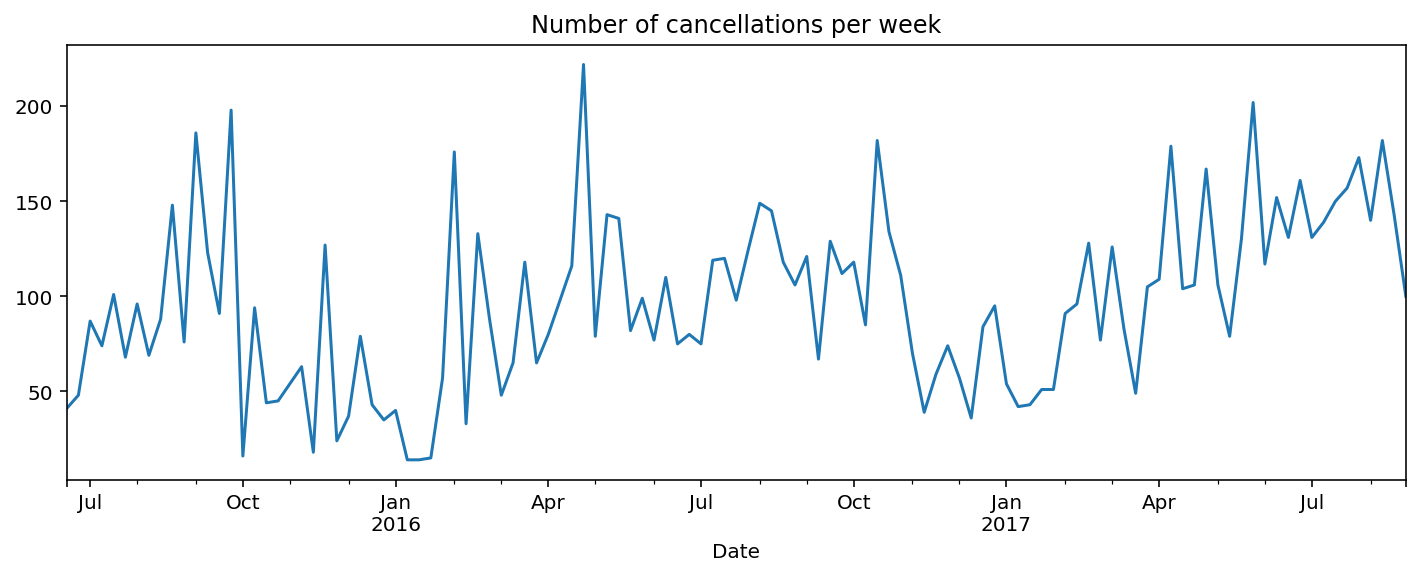

In [3]:
ts = pd.read_csv('data/h1weekly.csv', parse_dates=['Date'], index_col='Date', squeeze=True)

type(ts)
ts.head(2)
ts.tail(2)

_ = ts.plot(figsize=(12, 4), title='Number of cancellations per week')

In [4]:
ts.min(), ts.max()

(14, 222)

In [5]:
ts.describe().round(2)

count    115.00
mean      96.71
std       45.87
min       14.00
25%       64.00
50%       95.00
75%      127.50
max      222.00
Name: IsCanceled, dtype: float64

The manager has told you that the *minimum* number of cancellations recorded in a week was 14,  
while the *maximum* number of cancellations recorded in a week was 222.

Using only this information, you have been instructed to make an assumption about the mean and standard deviation of the distribution, for example the manager is not allowing you to look at the dataset and compute these directly, as he/she believes that the sample size is not large enough to infer the true mean and standard deviation from the data available.

Your assumptions regarding the mean and standard deviation are known as your **prior** assumptions, and you are assuming that weekly hotel cancellations follow a normal distribution.

With this information, you are required to do the following:
- Use PyMC3 to generate a predictive *posterior distribution*, such as a distribution that reflects an updated estimate of the mean and standard deviation given the data in question. (Hint: Make sure your standard deviation is sizable enough to account for the fact that your prior mean estimate may have been significantly different from the true estimate.)
- Report the mean and standard deviation as generated by the posterior distribution.

PyMC3 documentation: [General API Quickstart](https://docs.pymc.io/notebooks/api_quickstart.html)

#### Sampling 
<a id="sampling"></a>
[To the Top](#top)

Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC3 supports two broad classes of inference: *sampling* and variational inference.

The main entry point to MCMC sampling algorithms is via the `pm.sample()` function. By default, this function tries to auto-assign the right sampler(s) and auto-initialize if you don’t pass anything.

With PyMC3 version >=3.9 the `return_inferencedata=True` kwarg makes the sample function return an `arviz.InferenceData` object instead of a `MultiTrace`.

`InferenceData` has many advantages, compared to a `MultiTrace`: For example it can be saved/loaded from a file, and can also carry additional (meta)data such as date/version, or posterior predictive distributions. Take a look at the [ArviZ Quickstart](https://arviz-devs.github.io/arviz/getting_started/Introduction.html) to learn more.

In [6]:
# Define priors (one's beliefs about mu and sigma) and generate 1,000 samples
mu_prior = 120
sigma_prior = 10

with pm.Model() as model:
    mu = pm.Normal('mu', mu=mu_prior, sigma=sigma_prior)
    sd = pm.HalfNormal('sd', sigma=sigma_prior)
    obs = pm.Normal('obs', mu=mu, sigma=sd, observed=ts)
    
    idata = pm.sample(1_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


#### Analyze sampling results 
<a id="analyze-sampling-results"></a>
[To the Top](#top)

The most common used plot to analyze sampling results is the so-called trace-plot:

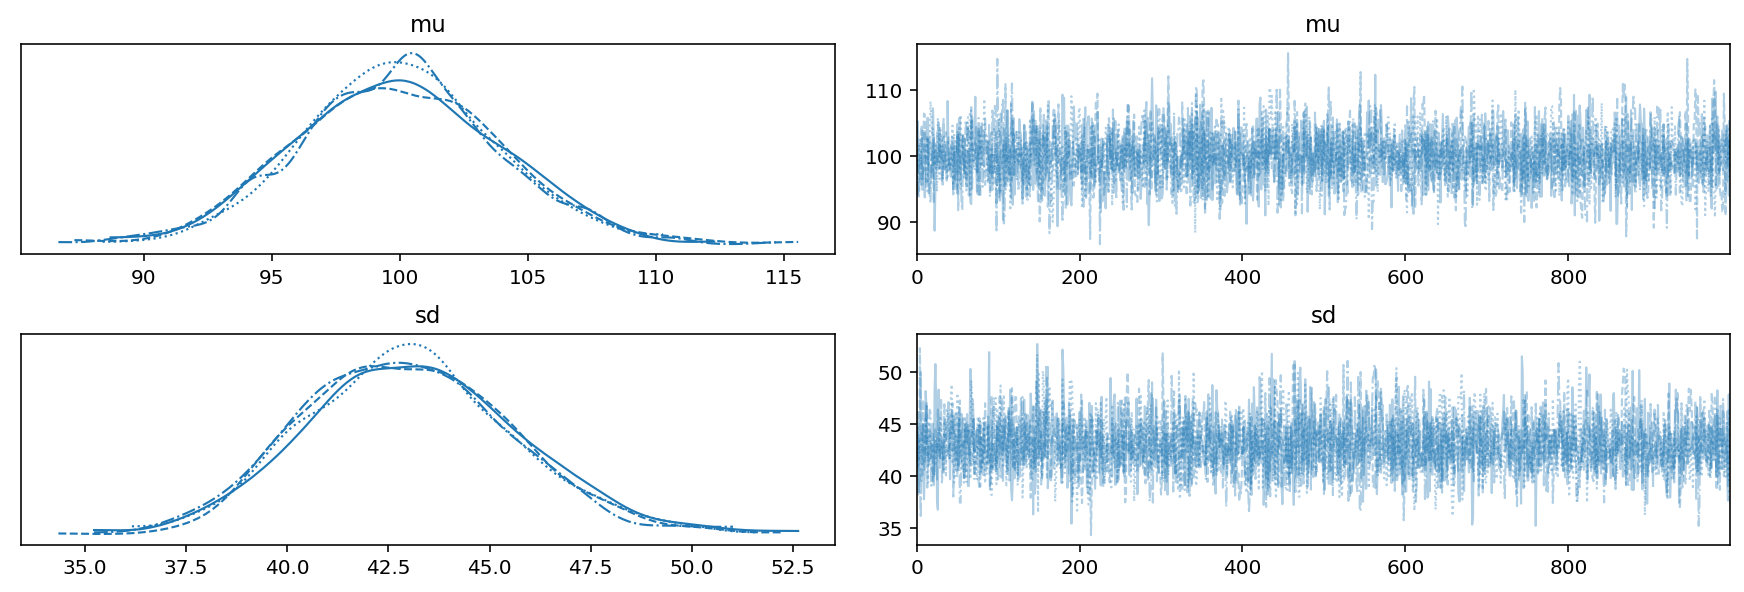

In [7]:
az.plot_trace(idata);

Another common metric to look at is R-hat, also known as the Gelman-Rubin statistic:

In [8]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,99.938,3.883,93.146,107.597,0.066,0.047,3486.0,3459.0,3500.0,2570.0,1.0
sd,43.028,2.603,38.215,47.823,0.045,0.032,3365.0,3332.0,3402.0,2453.0,1.0


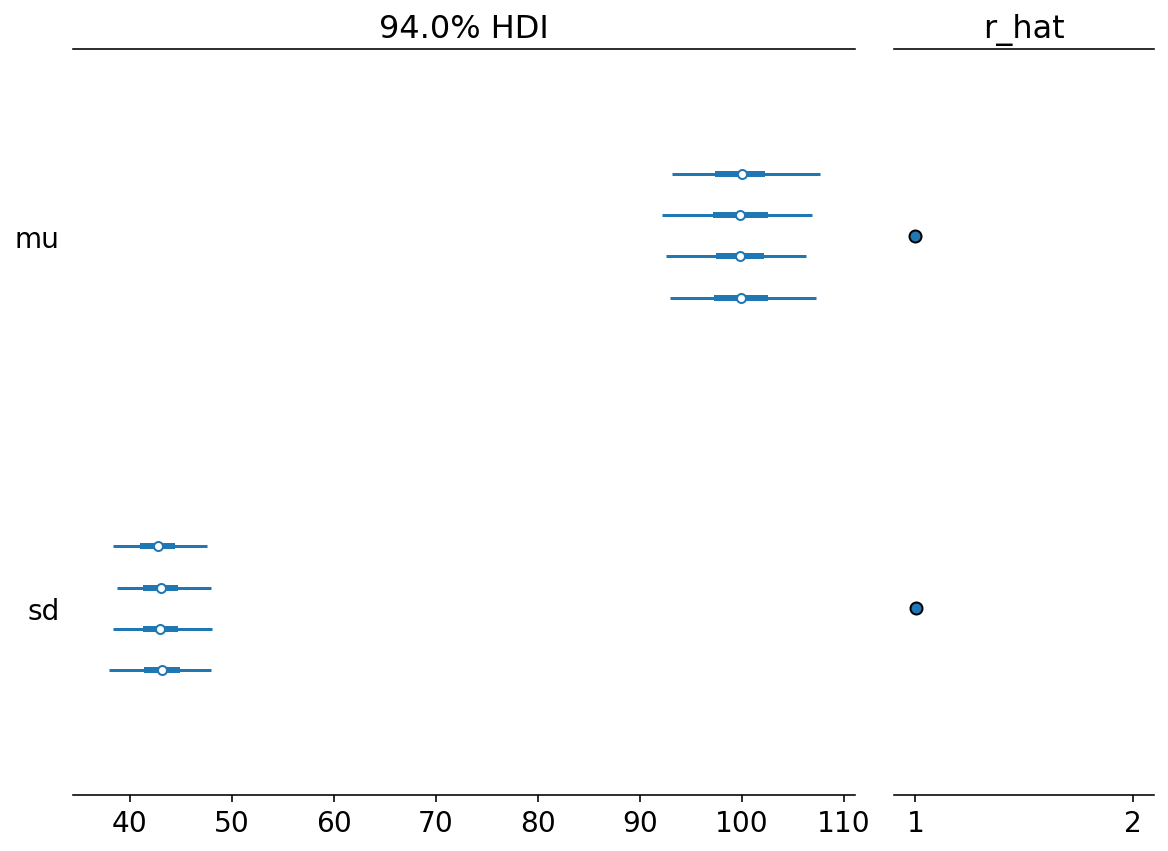

In [9]:
az.plot_forest(idata, r_hat=True);

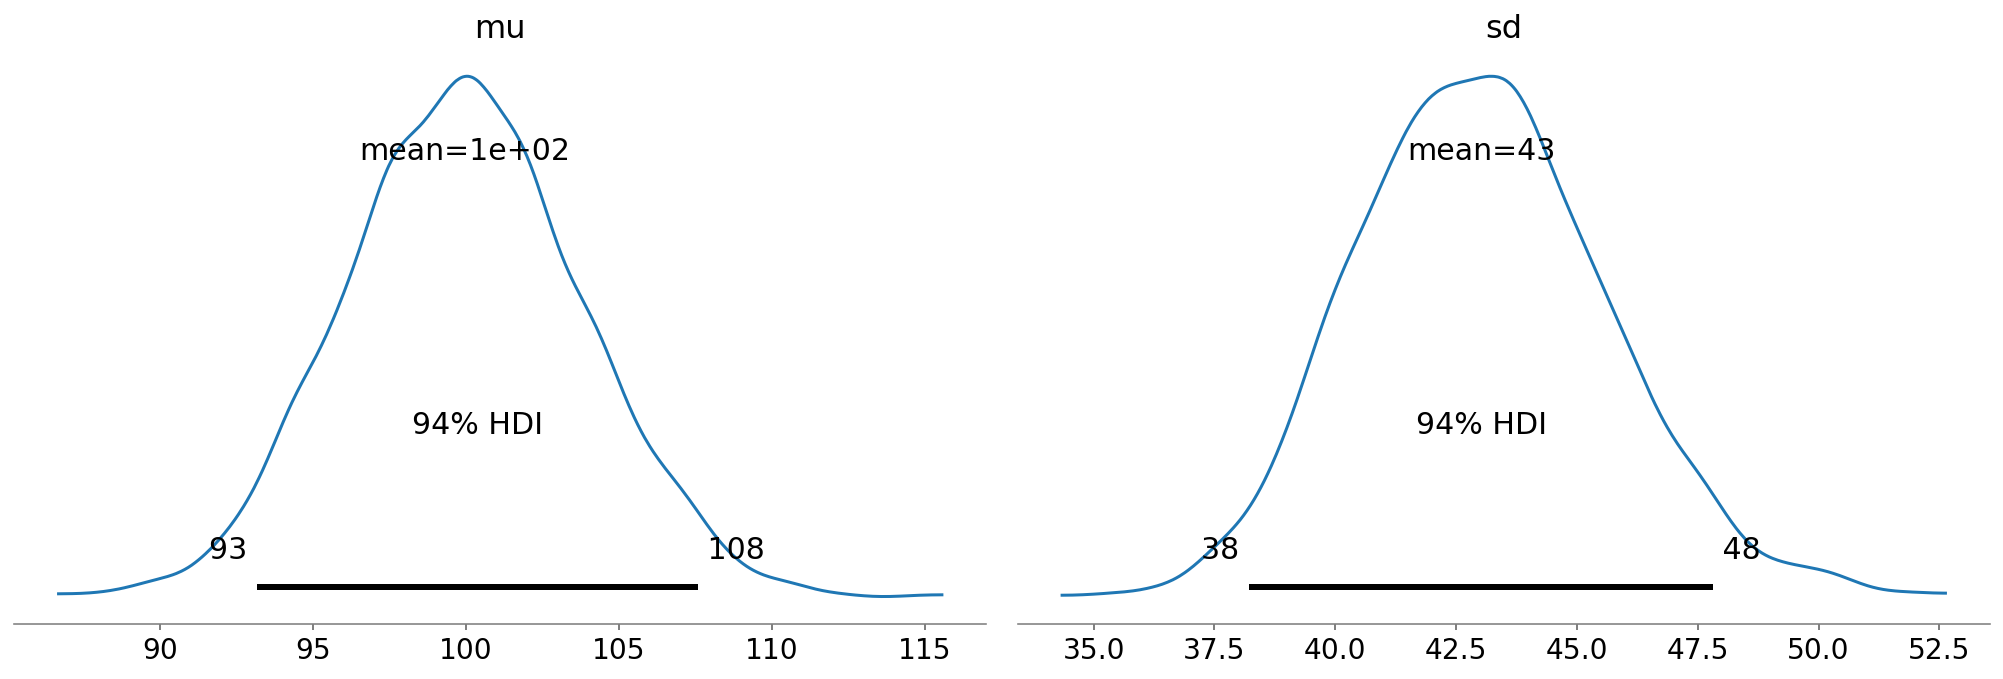

In [10]:
az.plot_posterior(idata);

#### Posterior Predictive Sampling
<a id="posterior-predictive-sampling"></a>
[To the Top](#top)

The `sample_posterior_predictive()` function performs prediction on hold-out data and posterior predictive checks.

In [11]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)

# Add posterior predictive to the InferenceData
az.concat(idata, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

/Users/dimitri/opt/miniconda3/envs/ts-forecasting/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


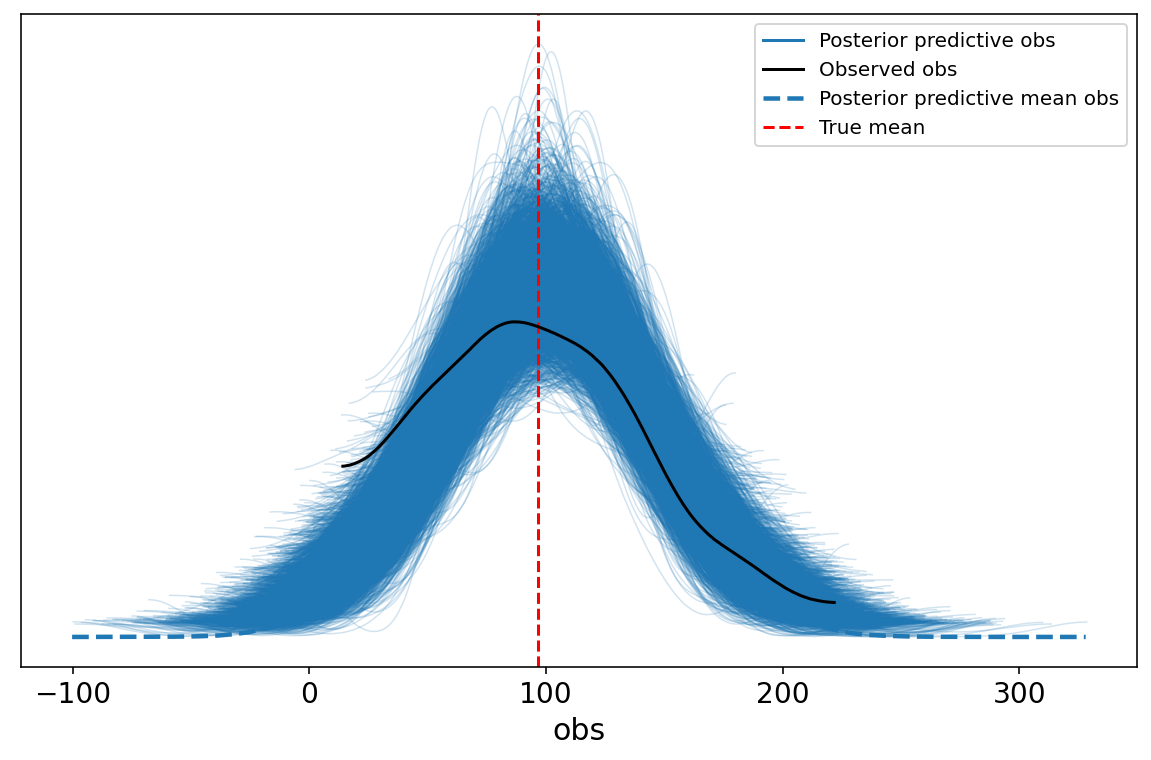

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_ppc(idata, ax=ax)
ax.axvline(ts.mean(), ls='--', color='r', label='True mean')
ax.legend(fontsize=10);

## Milestone 2: AR(1) Time Series Analysis
<a id="milestone-2"></a>
[To the Top](#top)

One of the members on your team suspects that weekly hotel cancellations follow an *AR(1) process*, for example a high degree of dependency between an observation at time `t` and its immediately preceding value at time `t-1`. However, they suspect that two years of time series data is not enough to prove this definitively. Therefore, the team decides to *use Bayesian methods* in lieu of classical statistical methods to determine if an AR(1) process exists.

They have tasked you with using Bayesian methods to identify the mean value of the AR(1) term. You will generate a probability distribution to identify this which will show the mean as well as the approximate range of potential AR(1) values as indicated by the distribution.

In addition, the team is also interested if a moving average of the data shows a stronger AR(1) process as opposed to the weekly data in its own right. They instruct you to form a moving average of the data and obtain an updated AR(1) value for this *smoothed time series*. You are given discretion as to which value you choose to use. (Does the mean value increase or decrease?)

- [Analysis of an AR(1) Model in PyMC3](https://docs.pymc.io/notebooks/AR.html)

#### AR(1) model for `ts`
<a id="ar1-model-for-ts"></a>
[To the Top](#top)

In [13]:
with pm.Model() as ar1:
    # Effect of lagged value on current value
    theta = pm.Uniform('theta', lower=-1, upper=1)
    
    # Precision of the innovation term
    tau = pm.Gamma('tau', mu=1, sd=1)
    
    obs = pm.AR1('observed', k=theta, tau_e=tau, observed=ts)
    
    idata = pm.sample(2_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.


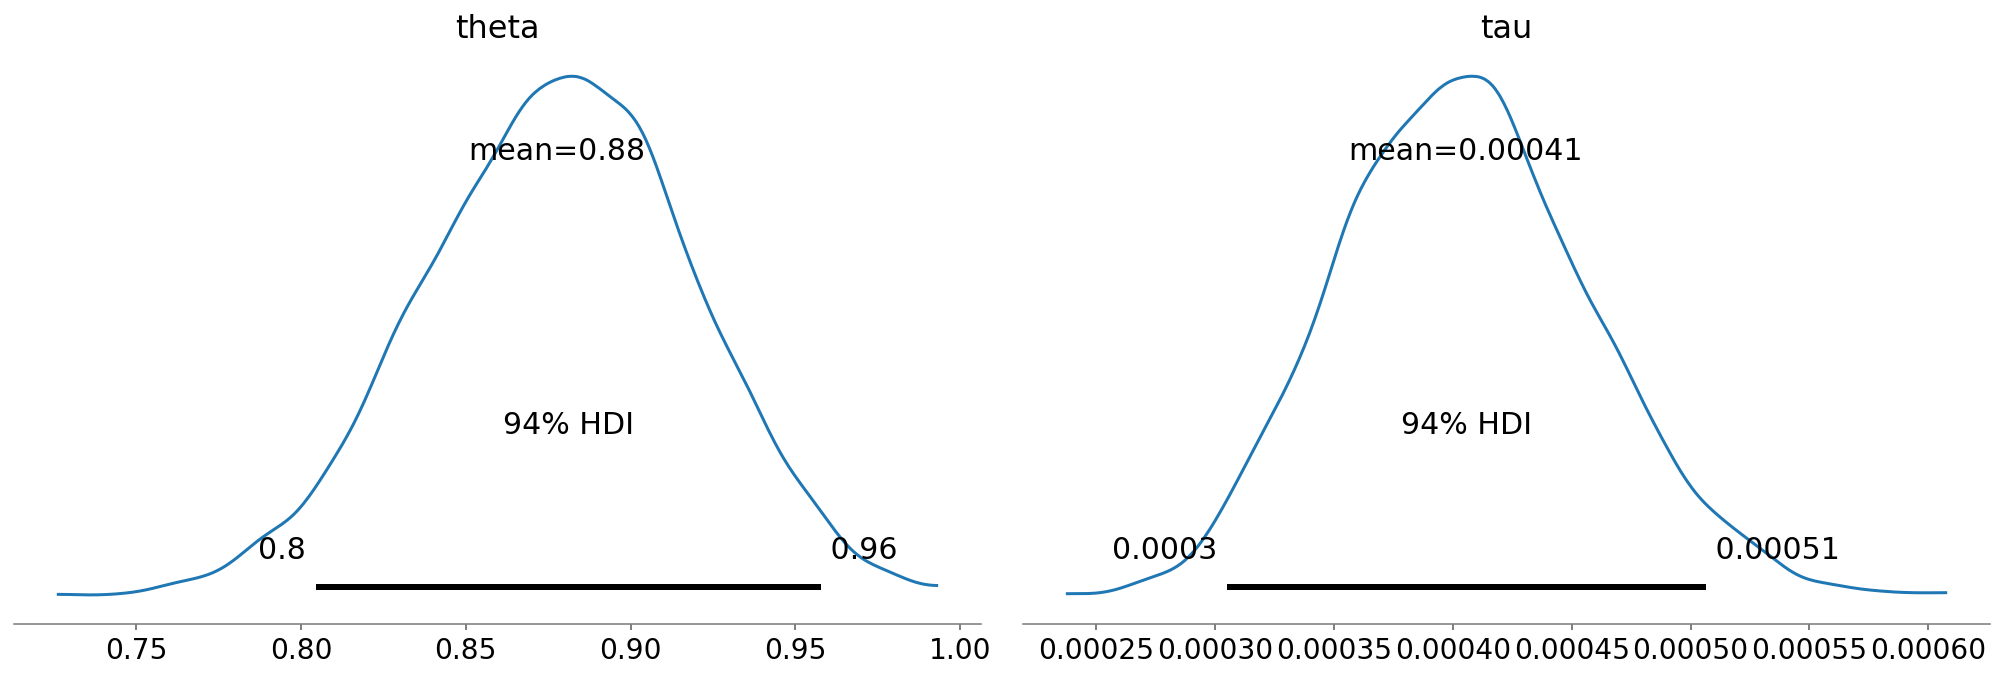

In [14]:
az.plot_posterior(idata);

In [17]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.878,0.041,0.804,0.958,0.001,0.0,4930.0,4797.0,4770.0,2860.0,1.0
tau,0.000,0.000,0.000,0.001,0.000,0.0,4762.0,4700.0,4776.0,4347.0,1.0


#### AR(1) model for smoothed `ts`
<a id="ar1-model-for-smoothed-ts"></a>
[To the Top](#top)

Date
2015-06-21   NaN
2015-06-28   NaN
Name: IsCanceled, dtype: float64

Date
2017-08-20    159.50
2017-08-27    141.25
Name: IsCanceled, dtype: float64

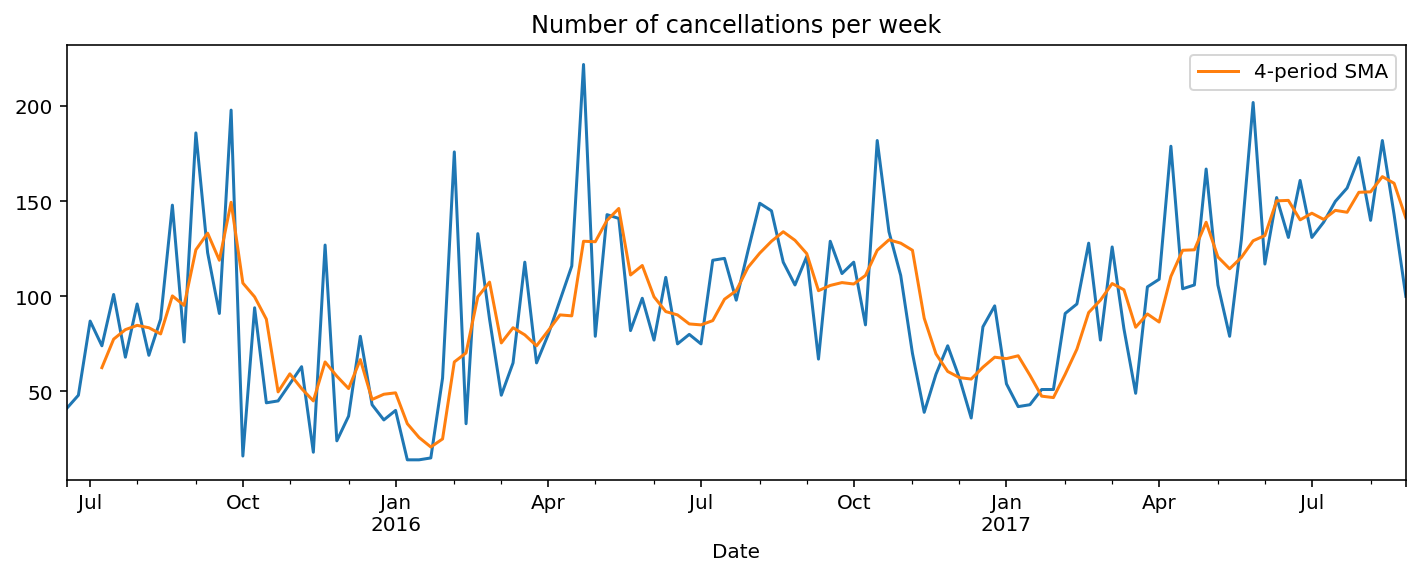

In [18]:
window_size = 4  # 4 weeks ~ 1 month
smoothed_ts = ts.rolling(window_size).mean()

smoothed_ts.head(2)
smoothed_ts.tail(2)

ax = ts.plot(figsize=(12, 4), title='Number of cancellations per week', label='')
ax = smoothed_ts.plot(ax=ax, label='4-period SMA')

_ = ax.legend()

In [21]:
with pm.Model() as ar1_smoothed:
    # Effect of lagged value on current value
    theta = pm.Uniform('theta', lower=-1, upper=1)
    
    # Precision of the innovation term
    tau = pm.Gamma('tau', mu=1, sd=1)
    
    obs = pm.AR1('observed', k=theta, tau_e=tau, observed=smoothed_ts.dropna())
    
    idata_smoothed = pm.sample(2_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.986,0.008,0.972,0.999,0.0,0.0,3952.0,3938.0,3271.0,2423.0,1.0
tau,0.005,0.001,0.004,0.006,0.0,0.0,4039.0,4039.0,3960.0,3238.0,1.0


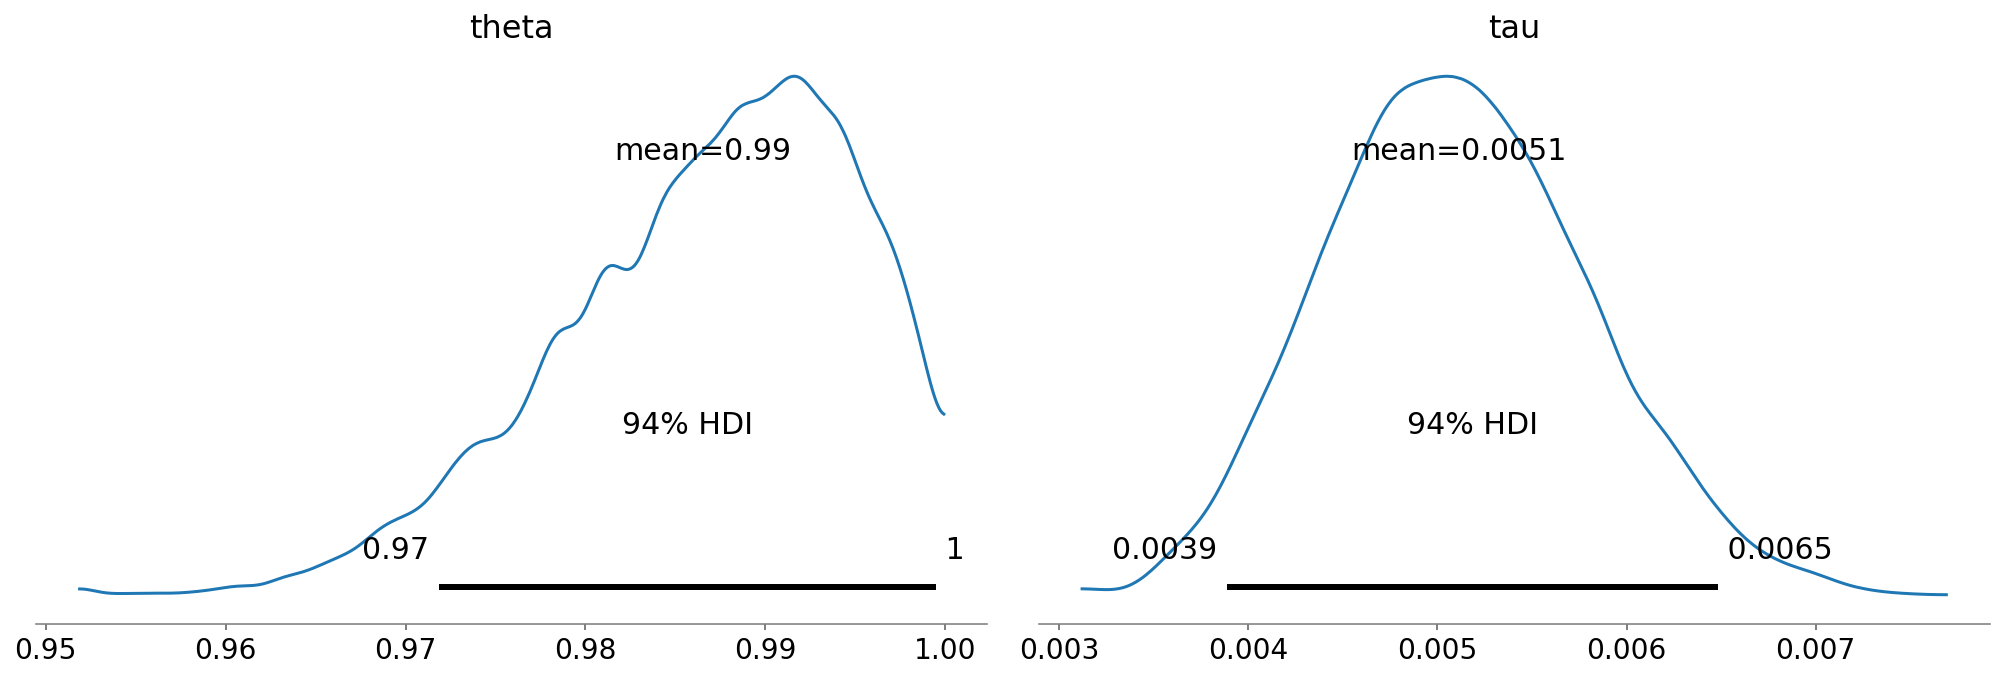

In [23]:
_ = az.plot_posterior(idata_smoothed)
az.summary(idata_smoothed)

## Milestone 3: Forecasting Volatility with Bayesian Time Series Methods
<a id="milestone-3"></a>
[To the Top](#top)

This part of the project is where you will model the volatility inherent in the time series in question.

This is an important aspect of Bayesian time series analysis as the majority of time series will not follow a normal distribution (or at least not perfectly). Instead, it is necessary to model volatility in order to capture short-term fluctuations in the overall series.

Use the [Case study 1: Stochastic volatility](https://docs.pymc.io/notebooks/getting_started#Case-study-1:-Stochastic-volatility) as a template for modeling the weekly volatility. It is up to you to determine the best format for your data and judge whether the volatility process is being modeled properly by the algorithm that you invoke.

Determine the proper format for your data. Such as in the stock returns example, daily returns are used instead of price. You should judge whether manipulation of the time series in this instance would be suitable or not.

#### Volatility Model 1
<a id="volatility-model-1"></a>
[To the Top](#top)

Follow the example in the [Case study 1: Stochastic volatility](https://docs.pymc.io/notebooks/getting_started#Case-study-1:-Stochastic-volatility) and build the model of Daily % changes.

count    114.0
mean       0.2
std        1.0
min       -0.9
25%       -0.3
50%        0.0
75%        0.4
max        6.1
Name: IsCanceled, dtype: float64

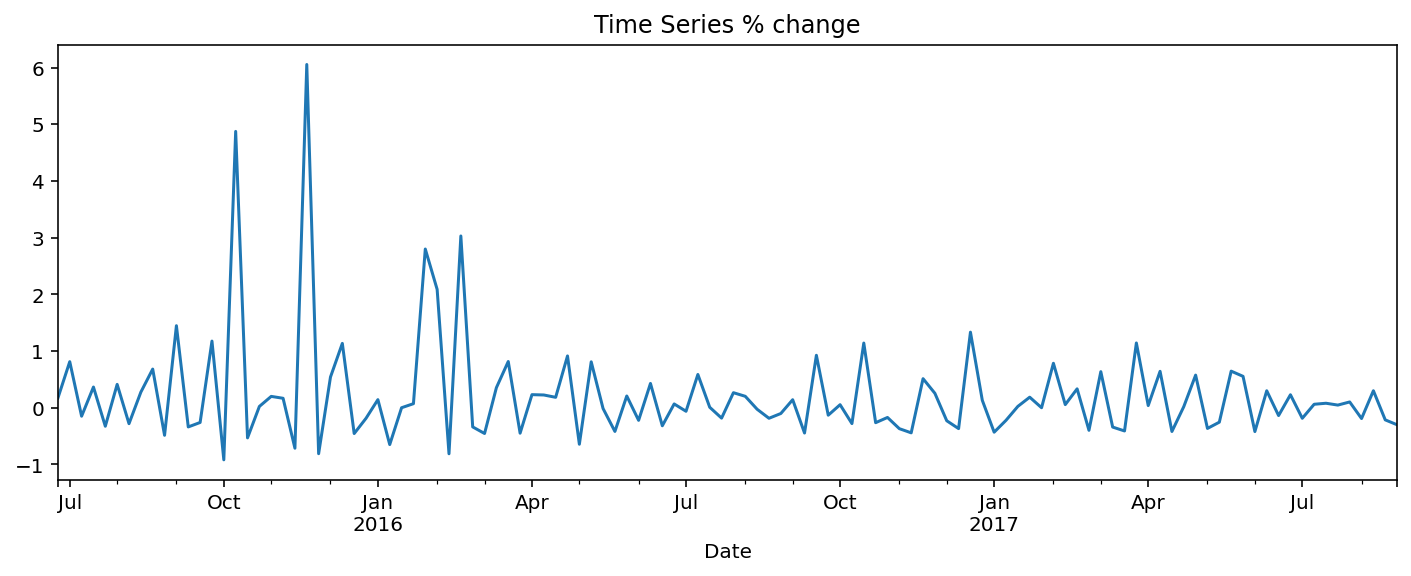

In [25]:
vol = ts.pct_change().dropna()

vol.describe().round(1)

_ = vol.plot(figsize=(12, 4), title='Time Series % change')

The model is using
- the exponential distribution to model the priors
- a random walk modeled on the Gaussian distribution to model the latent volatilities
- and the Student-T distribution to model the distribution of the time series.

In [26]:
with pm.Model() as vol_model:
    # The model remembers the datetime index with the name 'date'
    change_cancellations = pm.Data('cancellations', vol, dims='date', export_index_as_coords=True)

    nu = pm.Exponential('nu', 1 / 10.0, testval=5.0)
    sigma = pm.Exponential('sigma', 2.0, testval=0.1)

    # We can now figure out the shape of variables based on the index of the dataset
    s = pm.GaussianRandomWalk('s', sigma=sigma, dims='date')
    volatility_process = pm.Deterministic(
        'volatility_process', pm.math.exp(-2 * s) ** 0.5, dims='date'
    )

    r = pm.StudentT('r', nu=nu, sigma=volatility_process, observed=change_cancellations, dims='date')

vol_model.RV_dims

{'cancellations': ('date',),
 's': ('date',),
 'volatility_process': ('date',),
 'r': ('date',)}

In [34]:
with vol_model:
    idata = pm.sample(1_000, init='adapt_diag', return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 133 seconds.


0, dim: date, 114 =? 114


The acceptance probability does not match the target. It is 0.9111600424611335, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9226335183755736, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/dimitri/opt/miniconda3/envs/ts-forecasting/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0, dim: date, 114 =? 114
0, dim: date, 114 =? 114


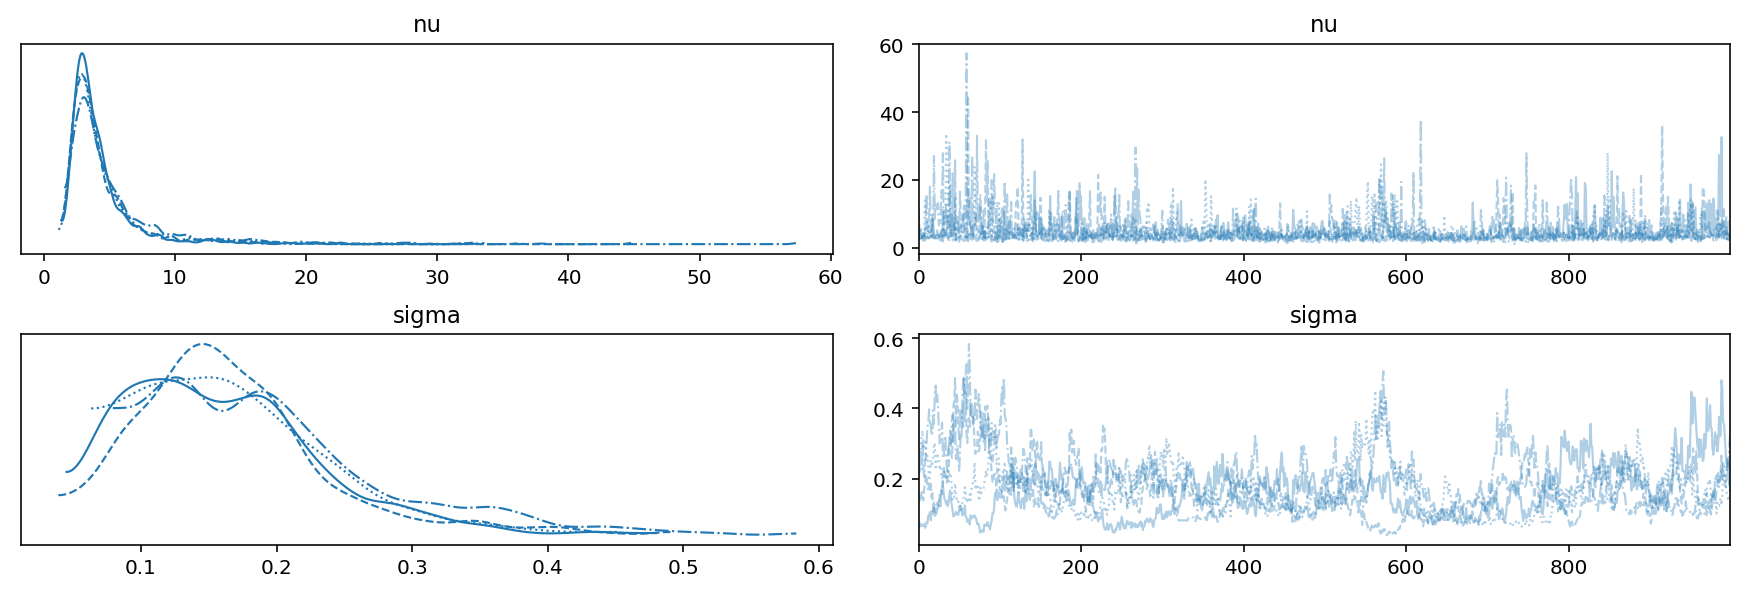

In [35]:
az.plot_trace(idata, var_names=('nu', 'sigma'));

In [75]:
np.exp(idata['s', ::5].T).shape
np.exp(idata['s', ::5].T)[:, 0].shape

(114, 800)

(114,)

**NOTE** (2021-03-06): ↓ does not work 🙁
```python
ax = vol.plot()
ax.plot(vol.index, 1 / np.exp(idata['s', ::5].T), 'C1', alpha=0.03)  # Does not show
```

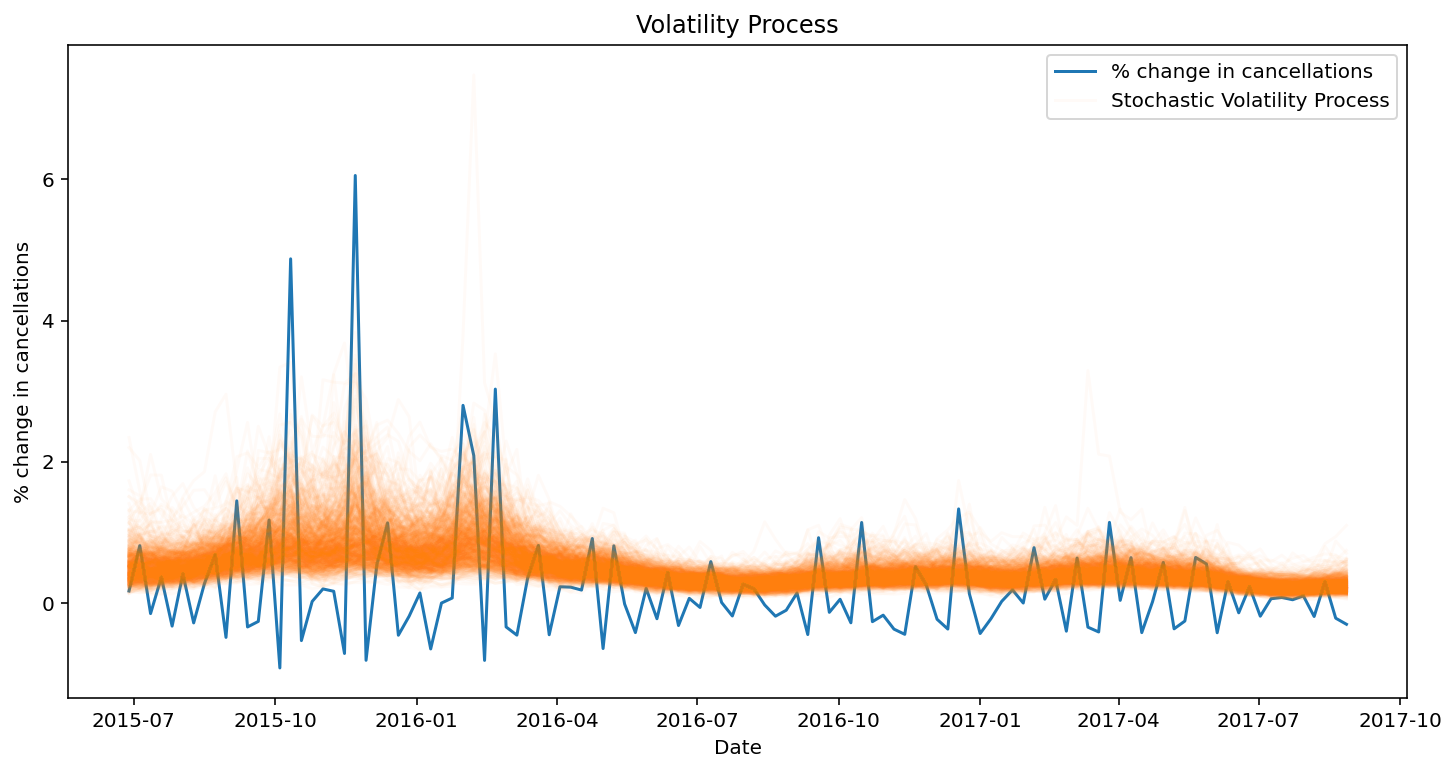

In [74]:
fig, ax = plt.subplots(figsize=(12, 6))

_ = ax.plot(vol.index, vol.values)
_ = ax.plot(vol.index, 1 / np.exp(idata['s', ::5].T), 'C1', alpha=0.03)
_ = ax.set(title='Volatility Process', xlabel='Date', ylabel='% change in cancellations')
_ = ax.legend(['% change in cancellations', 'Stochastic Volatility Process'], loc='upper right')

#### Volatility Model 2
<a id="volatility-model-2"></a>
[To the Top](#top)

⇉ Given that significant volatility is inherent in weekly cancellations, the same model is being used to model the volatility of this time series.

In [76]:
with pm.Model() as vol_model_2:
    # The model remembers the datetime index with the name 'date'
    cancellations = pm.Data('cancellations', ts, dims='date', export_index_as_coords=True)

    nu = pm.Exponential('nu', 1 / 10.0, testval=5.0)
    sigma = pm.Exponential('sigma', 2.0, testval=0.1)

    # We can now figure out the shape of variables based on the index of the dataset
    s = pm.GaussianRandomWalk('s', sigma=sigma, dims='date')
    volatility_process = pm.Deterministic(
        'volatility_process', pm.math.exp(-2 * s) ** 0.5, dims='date'
    )

    r = pm.StudentT('r', nu=nu, sigma=volatility_process, observed=cancellations, dims='date')
    
    idata = pm.sample(1_000, init='adapt_diag', return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.


0, dim: date, 115 =? 115


The acceptance probability does not match the target. It is 0.6395079607417525, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/dimitri/opt/miniconda3/envs/ts-forecasting/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0, dim: date, 115 =? 115
0, dim: date, 115 =? 115


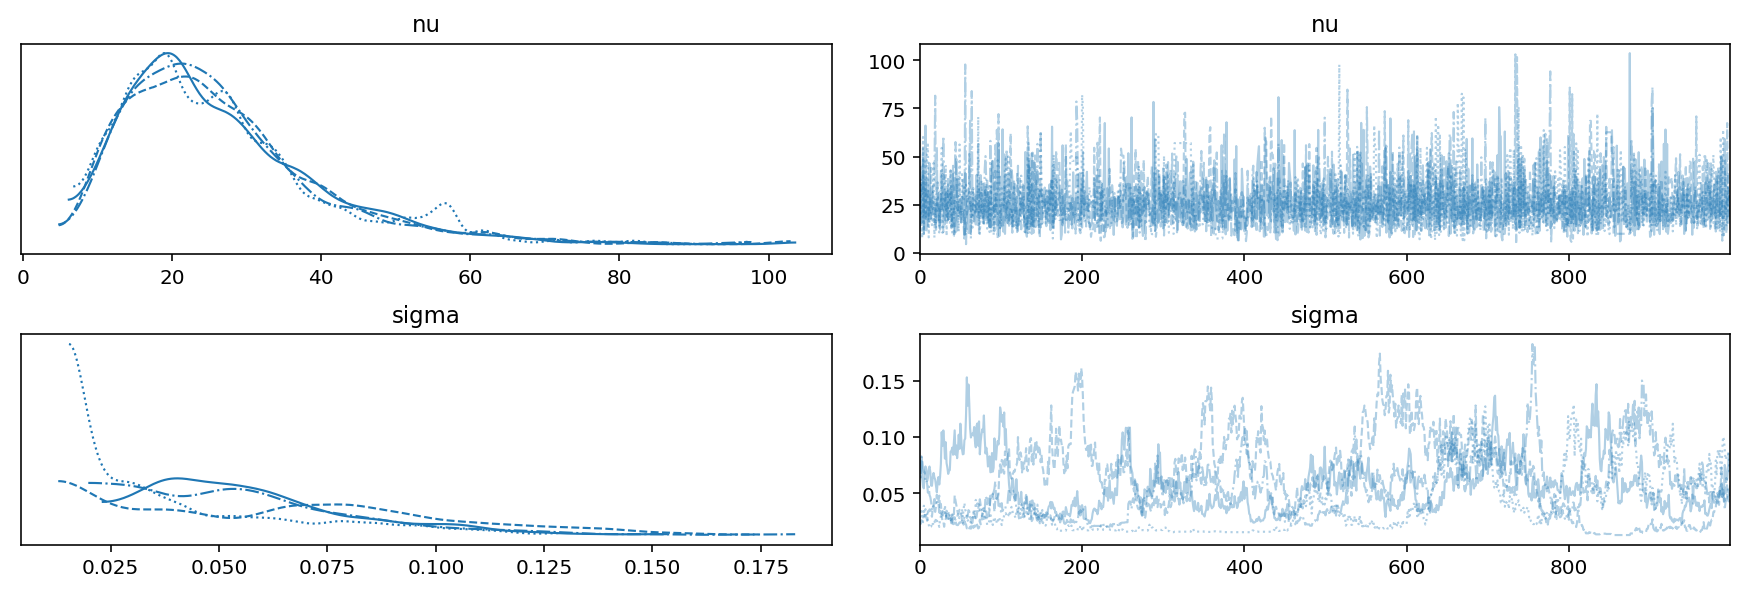

In [77]:
az.plot_trace(idata, var_names=('nu', 'sigma'));

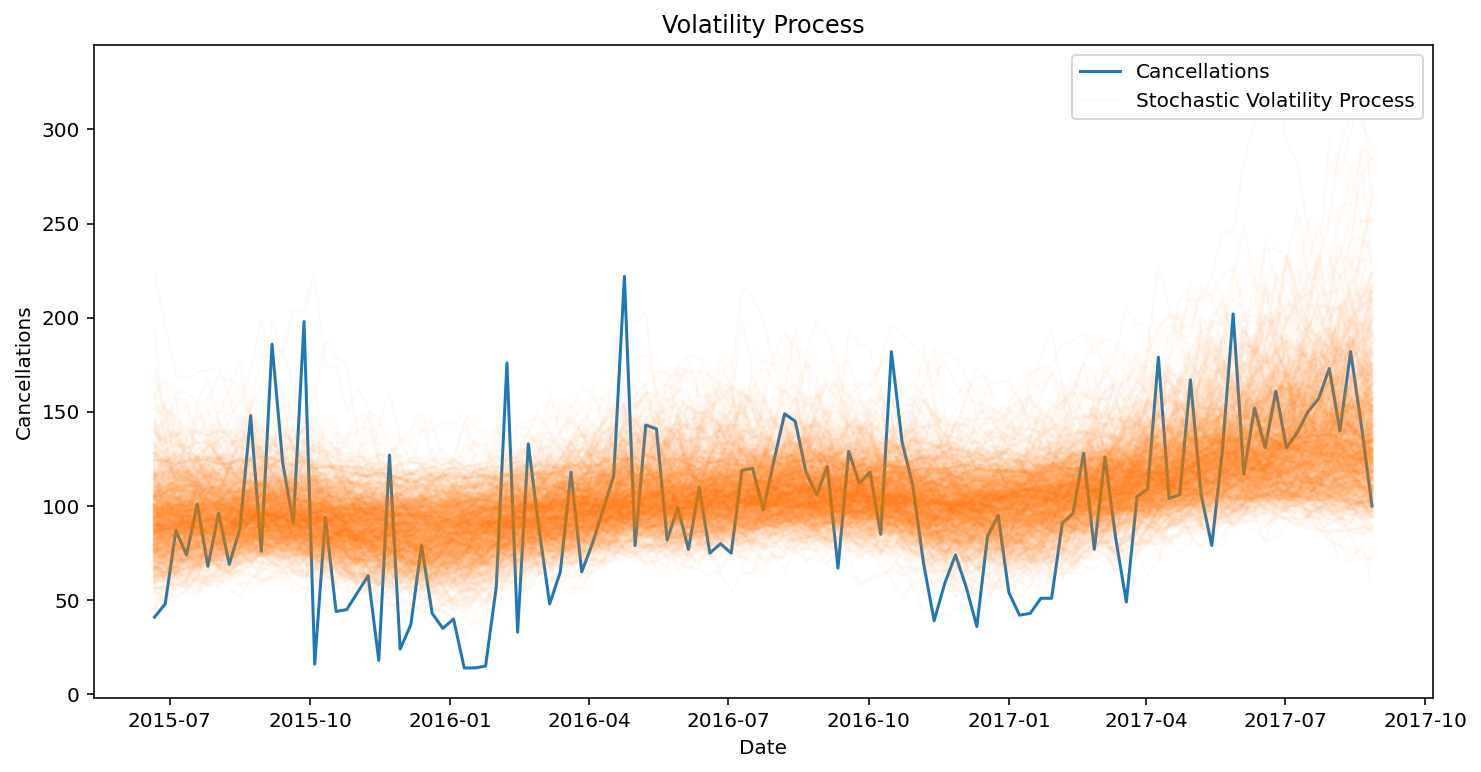

In [78]:
fig, ax = plt.subplots(figsize=(12, 6))

_ = ax.plot(ts.index, ts.values)
_ = ax.plot(ts.index, 1 / np.exp(idata['s', ::5].T), 'C1', alpha=0.03)
_ = ax.set(title='Volatility Process', xlabel='Date', ylabel='Cancellations')
_ = ax.legend(['Cancellations', 'Stochastic Volatility Process'], loc='upper right')